In [1]:
from pulp import * 
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

instance=utils.loadInstance("../instances/ins-1.txt")

print(*[f" {key} = {val}\n" for key,val in instance.items()])

 n = 4
  w = 8
  dim = [[3, 3], [3, 5], [5, 3], [5, 5]]



In [2]:
#PARAMETERS
M=1000
WC=instance["w"]
n=instance["n"]
p=[i[0] for i in instance["dim"]]
q=[i[1] for i in instance["dim"]]
Hmax=sum(q)

# DECISION VARIABLES
W=[] # Width of block
H=[] # Height of block
Xl=[] # left boundary of block
Xr=[] # right boundary of block
Yt=[] # top boundary of block
Yb=[] # bottom boundary of block
R=[] # 0 if block i is to the left of block j
U=[] # 0 if block i is below block j
V=[] # rotations

HC=LpVariable(f"H_c",0,Hmax,LpInteger)
for i in range(n):
    W.append(LpVariable(f"W_{i}",0,None,LpInteger))
    H.append(LpVariable(f"H_{i}",0,None,LpInteger))
    Xl.append(LpVariable(f"Xl_{i}",0,None,LpInteger))
    Xr.append(LpVariable(f"Xr_{i}",0,None,LpInteger))
    Yt.append(LpVariable(f"Yt_{i}",0,None,LpInteger))
    Yb.append(LpVariable(f"Yb_{i}",0,None,LpInteger))
    V.append(LpVariable(f"V_{i}",0,2,LpInteger))
    tempR=[]
    tempU=[]
    for j in range(n):
        if i!=j: 
            tempR.append(LpVariable(f"R_{i}_{j}",0,2,LpInteger))
            tempU.append(LpVariable(f"U_{i}_{j}",0,2,LpInteger))
        else:
            tempR.append(None)
            tempU.append(None)
    R.append(tempR)
    U.append(tempU)


In [3]:
# PROBLEM FORMULATION    
problem=LpProblem("VLSI_Problem", LpMinimize)

problem += HC, "Chip_Height"
for i in range(n):
    problem += Xr[i]-Xl[i]==W[i], f"B_{i}_boundaries_LR"
    problem += Yt[i]-Yb[i]==H[i], f"B_{i}_boundaries_TB"
    # problem += W[i]==p[i], f"B_{i}_width"
    # problem += H[i]==q[i], f"B_{i}_heigth"
    problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
    problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
    for j in range(n):
        problem += Yt[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"
        problem += Xr[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
        if i!=j:
            problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"
            problem += Xr[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
            problem += Yt[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
problem.solve(pulp.PULP_CBC_CMD(timeLimit=300, msg=1))
print("Status:",problem.status)

Status: 1


<Figure size 1080x1080 with 0 Axes>

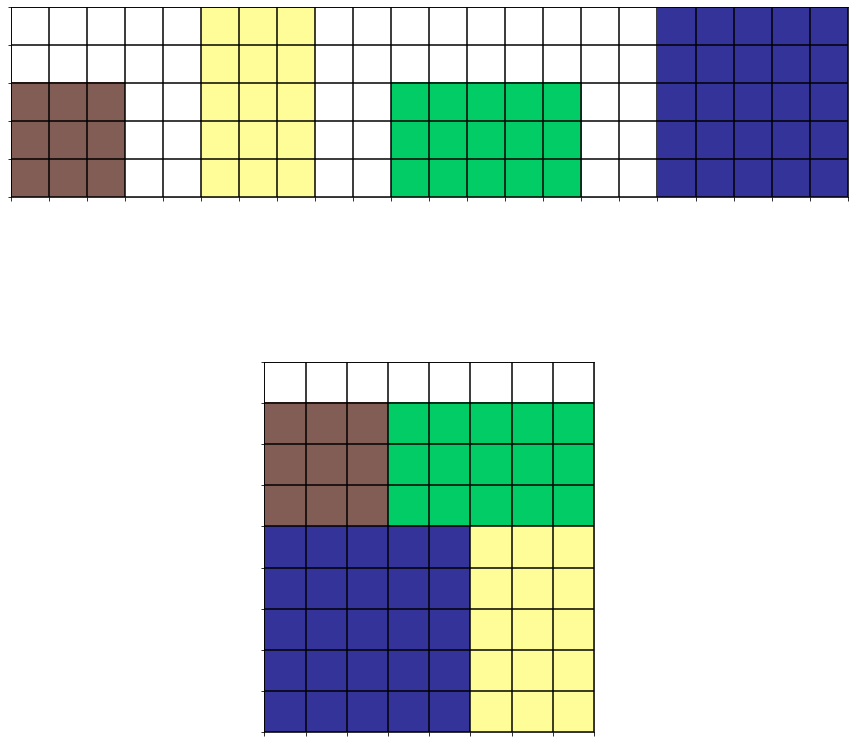

In [4]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(15,15))
solution=[[WC,int(HC.value())]]+[[p[i],q[i],int(Xl[i].value())+1,int(Yb[i].value())+1] for i in range(n)]

utils.show(solution,figsize=(15,15))
